<a href="https://colab.research.google.com/github/lucasphelipe18/Master1/blob/main/text_summarization_lucas.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Resumen de documentos - Método extractivo

Este cuaderno tiene como objetivo desarrollar un proceso capaz de producir resúmenes de texto a través de técnicas de PNL utilizando el método de extracción.

**Fuente de datos**

Los datos que usaremos en este trabajo se toman de Internet directamente del sitio de noticias de Associated Press. La sección 2 contiene el código crowler para capturar artículos.

**Métricas de evaluación**

Las métricas que usaremos en este trabajo están presentes en el paquete ROUGE. ROUGE incluye una serie de métricas destinadas a evaluar tareas de resumen y traducción de textos en el proceso de PNL (Procesamiento del Lenguaje Natural). A continuación se muestra una breve explicación de las principales métricas que utilizaremos:

- **ROUGE-N**: mide el número de aciertos de 'n-gramas' entre la salida del resumen generado por el modelo y el texto de referencia. 'n-gramas' es una agrupación de palabras/tokens. 1 gramo consiste en una sola palabra, 2 gramos se refiere a dos palabras consecutivas, etc. ROUGE-N, N se refiere al 'n-grama' que se utilizará para la evaluación.

- **ROUGE-L**: mide la secuencia más larga (LCS) entre la salida del modelo y la referencia. La idea es que cuantas más secuencias largas estén presentes en el resumen generado y en el texto de referencia, más similares serán estos textos.


- **Recall**: cuenta el número de n-gramas coincidentes encontrados en la salida del modelo y en el texto de referencia (verdades positivas) dividido por el número total de n-gramas en el texto de referencia.
<img src='https://miro.medium.com/max/1400/1*XEnhQJxKbEySimh1PPWPnQ.png' width=600>

-**Precisión**: se calcula de la misma manera que el recall, pero dividimos la cantidad de n-gramas que coinciden entre la salida del modelo y el texto de referencia por la cantidad total de n-gramas de la salida del modelo.
<img src='https://miro.medium.com/max/1400/1*aSd89F6kupr3znW71Qmb3Q.png' width=600>

- **F1-Score**: utiliza recall y precisión para evaluar una mejor relación entre estos:
<img src='https://miro.medium.com/max/1400/1*zYuwaCDNpYf51H5S4DpDRA.png' width=600>




##**1 - Preparando el Ambiente**

In [51]:
!pip install -U spacy

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [52]:
# download all data and models
#!sudo python -m spacy.en.download all
!sudo python3 -m spacy download en_core_web_sm

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 12.8 MB 5.5 MB/s 
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')


In [53]:
# instalando nltk, tool kit para trabajos con nlp
!pip install nltk

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [54]:
# download tokenized final cleaned
# !gdown --id 1YXkF_ugMx1HYCBBYF7VKq0Lujzif1JES

In [55]:
import pandas as pd
from tqdm.notebook import tqdm_notebook
tqdm_notebook.pandas() # usar .progress_apply() instead apply()

##**2 - Obtención y preparación de datos**


###**2.1 - Captura de datos de la web**

In [56]:
import requests
from bs4 import BeautifulSoup
from datetime import datetime
import pandas as pd
import json
import re

In [57]:
def striphtml(data):
    p = re.compile(r'<.*?>')
    return p.sub('', data)

In [58]:
def clean_story_text(story):
    p = re.compile(r'<.*?>')
    cleaned_article = story.replace('\\u003c','<')
    cleaned_article = striphtml(story.replace('\\u003c','<')).replace("___",' ').replace('\"',"").replace("'","")
    return cleaned_article

####**2.1.1 - Associated Press**

In [59]:
# =============================
# get associated press articles
# =============================
def getAPNewsFromCategory(category):
    page = requests.get('https://apnews.com/hub/' + category) 
    soup = BeautifulSoup(page.content, 'html.parser')
    results = soup.find_all('a')
    print('Find ', len(results), ' articles in ', category, '.')

    datePublisheds = []
    headlines = []
    descriptions = []
    articles = []
    categories = []

    for link in results:
        href = link.get('href')
        if('/article/' in href):
            page = requests.get('https://apnews.com/' + href) 
            soup = BeautifulSoup(page.content, 'html.parser')
            result = str(soup.find_all('script'))
            try:
                datePublished = result.split('"datePublished":',1)[1].partition(',"')[0].replace('\"',"").replace("'","")
                headline = result.split('"headline":',1)[1].partition(',"')[0].replace('\"',"").replace("'","")
                description = result.split('"description":',1)[1].partition(',"')[0].replace('\"',"").replace("'","")
                storyHTML = result.split('"storyHTML":',1)[1].partition(',"')[0].replace('\"',"").replace("'","")

                # print('datePublished:', datePublished)
                # print('\nheadline:', headline)
                # print('\ndescription:', description)
                # print('\nstoryHTML:', storyHTML)
                # print('\n\n------------------------\n\n')

                categories.append(category)
                datePublisheds.append(datePublished)
                headlines.append(headline)
                descriptions.append(description)
                articles.append(storyHTML)
                
            except:
                pass

    frame = {'category': categories, 'date_published': datePublisheds, 'headline': headlines, 'description': descriptions, 'story': articles }
    result = pd.DataFrame(frame)
    # df = pd.DataFrame (article, columns = ['story'])
    result.story = result.story.map(clean_story_text)

    return result

In [60]:
categories=['us-news','world-news','politics','sports','entertainment','business','technology','health','science']
articles = pd.DataFrame(columns=['category', 'date_published', 'headline', 'description','story'])
for cat in categories:
    df = getAPNewsFromCategory(cat)
    articles=articles.append(df)

articles = articles.drop_duplicates()


articles.to_csv('./articles.csv', index=False)  

Find  227  articles in  us-news .
Find  283  articles in  world-news .
Find  208  articles in  politics .
Find  257  articles in  sports .
Find  243  articles in  entertainment .
Find  263  articles in  business .
Find  210  articles in  technology .
Find  216  articles in  health .
Find  223  articles in  science .


In [61]:
# Limpiando datos vacíos 
article = articles.drop(articles[articles.story.str.len()==0].index, axis=0, inplace=True)

In [62]:
articles.shape

(564, 5)

In [63]:
# articles = pd.read_csv('./articles.csv')
# articles

###**2.2 - Limpiando el Dataset**

In [64]:
# usando datos capturados por scraping
df_articles = pd.DataFrame(columns=['document'])
df_articles.document = articles.story

In [65]:
# Eliminar líneas que pueden estar vacías en el salto del artículo
df_articles.dropna(inplace=True)

In [66]:
df_articles.head()

,document
0,"CLOVERLEAF, Texas (AP) — A 7-year-old boy died..."
2,SYDNEY (AP) — Australias government said Monda...
5,LONDON (AP) — Actor Kevin Spacey has been form...
8,AMSTERDAM (AP) — The Rolling Stones canceled t...
11,"Phoenix, Las Vegas, Denver and Californias Dea..."


Ahora que tenemos la lista de artículos en un conjunto de datos, procesemos los pasos de limpieza y formato para aplicar el algoritmo TextRank. Instalemos algunas bibliotecas enfocadas en tareas de PNL: nltk y spacy.

In [67]:
import nltk
nltk.download('punkt')

import re
import spacy
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import sent_tokenize, word_tokenize 

nlp = spacy.load('en_core_web_sm')
nltk.download('stopwords')
stopwords = stopwords.words('english')
punctuations = '!"#$%&\'()*+,-/:;<=>?@[\\]^_`{|}~©'

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [68]:
def cleanup_text(text):
    '''Clean some especial and new line caracteres'''
    # replaced = text.replace("b\'",'')
    replaced = text.replace("\n ","")  
    replaced = replaced.replace("\'s","")
    replaced = replaced.replace(" .",".")
    replaced = replaced.replace("  "," ")
    replaced = replaced.strip()
    return replaced

In [69]:
def process_text(docs, logging=False):
    '''Clean text and separeting tokens and convert do lowercase.'''
    texts = []
    
    # inc case of large docs, split docs in sentences
    sentences = sent_tokenize(docs)
    sent_cleaned = []
    for sent in sentences:
        # remove caracteres especiais
        sent=sent.replace("[^a-zA-Z0-9]"," ")
        doc = nlp(sent, disable=['parser', 'ner'])
        tokens = [tok.lemma_.lower().strip() for tok in doc if tok.lemma_ != '-PRON-']
        tokens = [tok for tok in tokens if tok not in stopwords and tok not in punctuations] 
        tokens = ' '.join(tokens)
        # tokens = tokens.replace("b\'",'')
        # tokens = tokens.replace("\\n ",'')  
        # tokens = tokens.replace("\\\'s",'') 
        # print(tokens)
        # tokens = tokens.strip()
        sent_cleaned.append(tokens)

    sent_cleaned = ' '.join(str(x) for x in sent_cleaned)
    texts.append(sent_cleaned)
    return pd.Series(texts)


In [70]:
df_articles.document[0]

0    CLOVERLEAF, Texas (AP) — A 7-year-old boy died...
0    KOLONSCHYNA, Ukraine (AP) — As Russian tanks a...
0    WASHINGTON (AP) — Members of the House committ...
0    A timeline of key events before, during after ...
0    NEW YORK (AP) — The Latest on the Tony Awards ...
0    AMSTERDAM (AP) — The Rolling Stones canceled t...
0    NEW YORK (AP) — Meltdowns in the cryptocurrenc...
0    AMSTERDAM (AP) — The Rolling Stones canceled t...
0    LAKE SAWA, Iraq (AP) — Hussam al-Aqouli rememb...
Name: document, dtype: object

In [71]:
# aplicar la función para limpiar los marcadores sobrantes de la conversión
# para codificación utf-8
df_articles['document_cleaned'] = df_articles['document'].progress_apply(cleanup_text)
df_articles['document_cleaned'][0]

  0%|          | 0/564 [00:00<?, ?it/s]

0    CLOVERLEAF, Texas (AP) — A 7-year-old boy died...
0    KOLONSCHYNA, Ukraine (AP) — As Russian tanks a...
0    WASHINGTON (AP) — Members of the House committ...
0    A timeline of key events before, during after ...
0    NEW YORK (AP) — The Latest on the Tony Awards ...
0    AMSTERDAM (AP) — The Rolling Stones canceled t...
0    NEW YORK (AP) — Meltdowns in the cryptocurrenc...
0    AMSTERDAM (AP) — The Rolling Stones canceled t...
0    LAKE SAWA, Iraq (AP) — Hussam al-Aqouli rememb...
Name: document_cleaned, dtype: object

In [72]:
# Limpiar el texto de los storys en una nueva feature
# convertir texto a minúsculas
# puntajes, etiquetas dejadas por spacy
# eliminar palabras con baja representación y palabras vacías
# del idioma inglés como preposiciones, pronombres y adverbios
df_articles['document_cleaned_formated'] = df_articles['document_cleaned'].progress_apply(process_text)
df_articles['document_cleaned_formated'][0]

  0%|          | 0/564 [00:00<?, ?it/s]

0    cloverleaf texas ap — 7 year old boy die strik...
0    kolonschyna ukraine ap — russian tank truck ru...
0    washington ap — member house committee investi...
0    timeline key event 1972 passage landmark u.s. ...
0    new york ap — late tony awards time local):11 ...
0    amsterdam ap — rolling stones cancel concert a...
0    new york ap — meltdown cryptocurrency space co...
0    amsterdam ap — rolling stones cancel concert a...
0    lake sawa iraq ap — hussam al aqouli remember ...
Name: document_cleaned_formated, dtype: object

In [73]:
# guardar el tamaño de los textos limpios y formateados como features
df_articles['document_cleaned_lenght'] = df_articles['document_cleaned'].str.len()
df_articles['document_cleaned_formated_lenght'] = df_articles['document_cleaned_formated'].str.len()

In [74]:
print('Líneas con texto vacío: ', len(df_articles[df_articles.document_cleaned_lenght<1]))

Líneas con texto vacío:  0


In [75]:
# guardar archivo con storys preprocesadas
df_articles.to_csv('articles.csv.gz', compression='gzip')

In [76]:
ls -l

total 4016
-rw-r--r-- 1 root root 2242702 Jun 13 17:47 articles.csv
-rw-r--r-- 1 root root  991279 Jun 13 17:49 articles.csv.gz
drwxr-xr-x 1 root root    4096 Jun  1 13:50 sample_data/
-rw-r--r-- 1 root root  866291 Jun 13 16:34 storys_summarized.csv.gz


##**3.0 - Exploratory Data Analysis**

**Analisando el tamaño de los documentos**

In [77]:
from matplotlib import pyplot as plt
import seaborn as sns
sns.set(style='whitegrid', palette='muted', font_scale=1.5)
plt.style.use('seaborn')

%matplotlib inline
%config inlineBackend.figure_format='retina'

Analizar las categorías de los artículos del conjunto de datos.

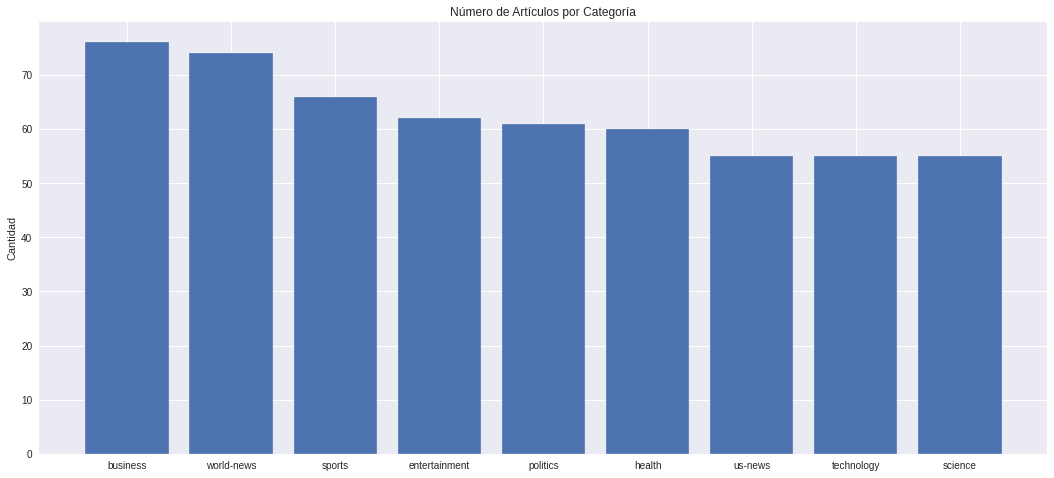

In [78]:
articles_cats = articles.category.value_counts().reset_index()

fig=plt.figure(figsize=(14,6))
ax = fig.add_axes([0,0,1,1])
ax.set_ylabel('Cantidad')
ax.set_title('Número de Artículos por Categoría')
ax.bar(articles_cats['index'], articles_cats.category)
plt.show()

Analizar la distribución del número de palabras en los artículos del conjunto de datos.

In [79]:
df_articles['document_cleaned_lenght'].describe()

count      564.000000
mean      3518.668440
std       2818.849812
min        392.000000
25%       1363.000000
50%       2548.000000
75%       6029.000000
max      15442.000000
Name: document_cleaned_lenght, dtype: float64

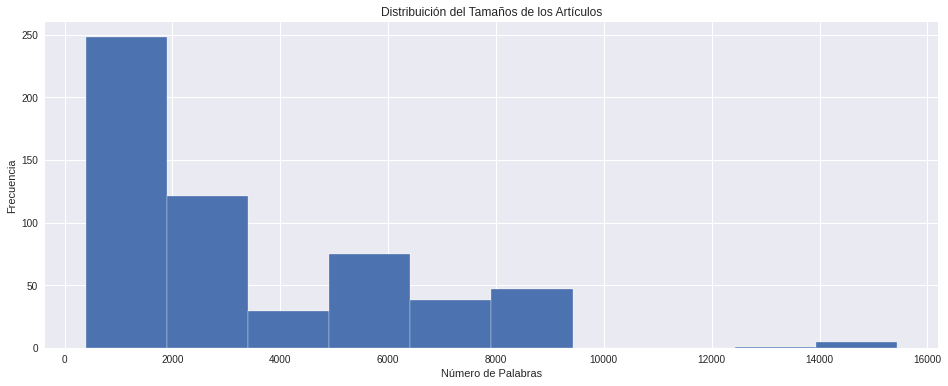

In [80]:
# Trazado del histograma del número de palabras en los artículos
plt.figure(figsize=(16,6))
plt.title("Distribuición del Tamaños de los Artículos")
plt.xlabel("Número de Palabras")
plt.ylabel("Frecuencia")
plt.hist(df_articles['document_cleaned_lenght'])
# marker_size = 15
plt.show()

In [81]:
df_articles['document_cleaned_formated_lenght'].describe()

count      564.000000
mean      2502.530142
std       2019.659178
min        300.000000
25%        990.000000
50%       1828.000000
75%       4290.000000
max      11041.000000
Name: document_cleaned_formated_lenght, dtype: float64

In [82]:
df_articles['document_cleaned_formated_lenght'].sort_values()

102      300
119      357
148      376
131      401
0        436
       ...  
80     11041
6      11041
38     11041
0      11041
86     11041
Name: document_cleaned_formated_lenght, Length: 564, dtype: int64

##**4 - Generando resumen**

###**4.1 - Uso de la biblioteca Spacy**

Para generar el resumen extractivo, una técnica es utilizar el algoritmo TextRank, derivado del PageRank desarrollado por Google. Este método consiste en encontrar las oraciones en un documento que tienen la clasificación más alta usando una frecuencia ponderada de las palabras en el documento. En este cuaderno vamos a utilizar una variación muy similar al algoritmo TextRank. A continuación se detallan los pasos que debemos realizar:

1. Convierta todos los documentos en oraciones;
2. Procesar el texto de las oraciones: convertir a minúsculas, eliminar palabras vacías y caracteres especiales;
3. Tokenizar las oraciones: tratar cada palabra (token) como un elemento a considerar en el cálculo de frecuencia;
4. Calcular la frecuencia ponderada: para cada palabra del texto calcularemos la frecuencia ponderada en relación con el documento. Haremos esto dividiendo la frecuencia de cada palabra por la frecuencia de la palabra que aparece con más frecuencia en el documento;
5. Sustituir palabras ponderadas más frecuentes en la oración original;
6. Ordenar las oraciones en orden descendente de suma de frecuencia;

In [83]:
#nltk.download('punkt')
import heapq

def generate_summary(text_without_removing_dot, cleaned_text, logging=False):
    sample_text = text_without_removing_dot

    if len(sample_text)>0:
        # Ingrese el documento de texto en la función spacy nlp
        doc = nlp(sample_text)
        # estamos usando spacy para la tokenización de oraciones
        sentence_list=[]
        for idx, sentence in enumerate(doc.sents): 
            sentence_list.append(re.sub(r'[^\w\s]','',str(sentence)))

        # obtener la lista de palabras vacías del inglés
        stopwords = nltk.corpus.stopwords.words('english')

        # calcular frecuencia de palabras - TF
        word_frequencies = {}  
        for word in nltk.word_tokenize(cleaned_text):  
            if word not in stopwords:
                if word not in word_frequencies.keys():
                    word_frequencies[word] = 1
                else:
                    word_frequencies[word] += 1

        # identificar una mayor frecuencia de palabras 
        maximum_frequncy = max(word_frequencies.values())

        # calcular una frecuencia de palabra inversa para la lista de palabras - TF-IDF
        for word in word_frequencies.keys():  
            word_frequencies[word] = (word_frequencies[word]/maximum_frequncy)

        # calcular puntajes para cada oración
        sentence_scores = {}  
        for sent in sentence_list:  
            for word in nltk.word_tokenize(sent.lower()):
                if word in word_frequencies.keys():
                    if len(sent.split(' ')) < 50: # número máximo de palabras en cada oración
                        if sent not in sentence_scores.keys():
                            sentence_scores[sent] = word_frequencies[word]
                        else:
                            sentence_scores[sent] += word_frequencies[word]

        # obtener siete oraciones de puntuación más alta
        summary_sentences = heapq.nlargest(7, sentence_scores, key=sentence_scores.get)
        summary = ' '.join(summary_sentences)

        # o si no se puede calcular ningún resumen, primera oración
        if len(summary) == 0:
            summary = sentence_list[0]

        if logging:
            print("Original Text:\n")
            print(text_without_removing_dot)
            print('\n\nSummarized text:\n')
            print(summary)
    else:
        summary = sample_text
    
    return summary

Prueba de la función de resumen con el primer elemento del conjunto de datos de artículos.

In [84]:
type(df_articles.document_cleaned)

pandas.core.series.Series

In [85]:
df_articles.document_cleaned.values[0]

'CLOVERLEAF, Texas (AP) — A 7-year-old boy died after he was struck by gunfire that was shot into his Texas home as he slept in bed, police said.The child was shot about 10:45 p.m. Sunday at his familys home in the Houston-area city of Cloverleaf, Harris County Sheriffs Sgt. Jason Brown said. Someone in a silver sedan fired multiple rounds into the home, authorities said.The boys bedroom was near the front of the home, authorities said. He was struck in the chest and ran to his mother, but later died at a hospital, authorities said.No one has been arrested, the sheriffs office said, and the motive for the shooting wasnt yet known.'

In [86]:
len(generate_summary(df_articles.document_cleaned.values[0], df_articles.document_cleaned_formated.values[0], logging=False))

615

In [87]:
# generar el resumen del primer artículo
generate_summary( df_articles['document_cleaned'].values[0], df_articles['document_cleaned_formated'].values[0], logging=True)

Original Text:

CLOVERLEAF, Texas (AP) — A 7-year-old boy died after he was struck by gunfire that was shot into his Texas home as he slept in bed, police said.The child was shot about 10:45 p.m. Sunday at his familys home in the Houston-area city of Cloverleaf, Harris County Sheriffs Sgt. Jason Brown said. Someone in a silver sedan fired multiple rounds into the home, authorities said.The boys bedroom was near the front of the home, authorities said. He was struck in the chest and ran to his mother, but later died at a hospital, authorities said.No one has been arrested, the sheriffs office said, and the motive for the shooting wasnt yet known.


Summarized text:

CLOVERLEAF Texas AP  A 7yearold boy died after he was struck by gunfire that was shot into his Texas home as he slept in bed police said The child was shot about 1045 pm Sunday at his familys home in the Houstonarea city of Cloverleaf Harris County Sheriffs Sgt Someone in a silver sedan fired multiple rounds into the home au

'CLOVERLEAF Texas AP  A 7yearold boy died after he was struck by gunfire that was shot into his Texas home as he slept in bed police said The child was shot about 1045 pm Sunday at his familys home in the Houstonarea city of Cloverleaf Harris County Sheriffs Sgt Someone in a silver sedan fired multiple rounds into the home authorities said The boys bedroom was near the front of the home authorities said No one has been arrested the sheriffs office said and the motive for the shooting wasnt yet known He was struck in the chest and ran to his mother but later died at a hospital authorities said Jason Brown said'

Ahora procesando el conjunto de datos completo:

In [88]:
# Crear una nueva columna para almacenar el resumen generado
df_articles['generated_summary'] = df_articles.progress_apply(lambda x: generate_summary(x.document_cleaned, x.document_cleaned_formated), axis=1)
df_articles['generated_summary_lenght'] = df_articles['generated_summary'].str.len()


  0%|          | 0/564 [00:00<?, ?it/s]

In [89]:
# comprobar el tamaño del storys original y el resumen
len(df_articles.document[0]), len(df_articles.generated_summary[0])

(9, 9)

In [90]:
# comparar el tamaño de los strings del artículo original y del resumen
df_articles.document.str.len().mean(), df_articles.generated_summary.str.len().mean()

(3519.053191489362, 1154.040780141844)

In [91]:
df_articles.document.str.len().min(), df_articles.generated_summary.str.len().min()

(392, 297)

In [92]:
# Resumen del primer artículo
df_articles.generated_summary.values[0]

'CLOVERLEAF Texas AP  A 7yearold boy died after he was struck by gunfire that was shot into his Texas home as he slept in bed police said The child was shot about 1045 pm Sunday at his familys home in the Houstonarea city of Cloverleaf Harris County Sheriffs Sgt Someone in a silver sedan fired multiple rounds into the home authorities said The boys bedroom was near the front of the home authorities said No one has been arrested the sheriffs office said and the motive for the shooting wasnt yet known He was struck in the chest and ran to his mother but later died at a hospital authorities said Jason Brown said'

In [93]:
# guardar archivo con las storys preprocesadas
df_articles.to_csv('storys_summarized.csv.gz', compression='gzip')

##**5 - Evaluación del resultado**

###**5.1 - Calculando las métricas Rouge**

para calcular las métricas de ROUGE usaremos la biblioteca de rouge disponible para la instalación a través de pip.

In [94]:
# instalando lib rouge. Observe que se elija la versión 1.0.1.
!pip install rouge

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


La función get_scores recupera las métricas definidas en el parámetro:

In [95]:
# calcular métricas rouge para todo el conjunto de datos
from rouge import Rouge
rouge = Rouge(metrics=['rouge-1', 'rouge-2', 'rouge-l'])
# rouge = Rouge(metrics=['rouge-n', 'rouge-l', 'rouge-w'])

# el parámetro avg=True calcula el promedio del conjunto de datos
rouge.get_scores(df_articles.generated_summary.values,
                 df_articles.document.values, 
                 avg=True)

{'rouge-1': {'f': 0.5936264106633103,
  'p': 0.8976772413802734,
  'r': 0.47202342652237333},
 'rouge-2': {'f': 0.49387006852081283,
  'p': 0.786496669720652,
  'r': 0.3904743596292433},
 'rouge-l': {'f': 0.5901728825125092,
  'p': 0.890735296467876,
  'r': 0.4696493137575506}}

###**5.2 - Conclusión**

Al observar las tres métricas, notamos que la precisión tiene un resultado cercano a 1 (cuanto más cercano a 1, mejor), es decir, el modelo está encontrando grandes partes de los n-gramas coincidentes en el texto de referencia y en el resumen. Si consideramos el rouge-2 podemos ver una precisión de 0.7853.

Sin embargo, el recuerdo es bajo, lo que indica que el número de n-gramas presentes en los dos textos comparativos (modelo y referencia) están muy por debajo de los n-grans del texto de referencia. Esto se debe al hecho de que los artículos elegidos para nuestro conjunto de datos son textos extensos.

El resultado parece satisfactorio, ya que los bachmarks con métodos de resumen extractivo tienen valores de rouge y f1 cercanos a estos.